# Basic format for learning algorithm design

While there are innumerable strategies for implementing machine learning techniques, we take an approach centered around three core objects: __data__, __models__, and __algorithms__. Their characteristics are as follows:

- __Data object:__ This is a class object which is used to store the data used for training, validation, and testing as necessary.
- __Model object:__ This is a class object which implements functions which take both data objects and algorithm states as arguments. These functions are used for both training and evaluation.
- __Algorithm object:__ This is an iterator (class) object which maintains a "state" characterized by, e.g., a parameter vector, a cumulative tally of the resources used thus far, and so forth. At each iterative update, the algorithm calls methods which take both data and model objects as arguments.

In this way, this triumvirate of learning offers us a great deal of flexibility since each of the triumvirs can work with numerous combinations of others.

As a concrete example, in a supervised learning setting, one would have distinct models corresponding to least-squared linear regression, robust (Huber-loss) regression, and $\ell_{1}$-regularized sparse regression. Many algorithms are possible, but for example a (sub-) gradient descent algorithm object can be implemented once, and be re-used for all these distinct models. For pedagogical purposes and prototyping of new methods, I find this approach to be quite useful.

__Contents:__

- <a href="#trivial">Implementing a trivial algorithm</a>

- <a href="#link3">Linking up the data-model-algorithm trio</a>

- <a href="#paraEval">Evaluating the impact of parameter settings</a>

- <a href="#learning">From optimization to learning</a>

- <a href="#FDGD">More examples: finite-difference GD</a>

- <a href="#SGD">More examples: stochastic GD</a>

- <a href="#SVRG">More examples: </a>

<a id="trivial"></a>
## Implementing a trivial algorithm

As a very simple initial example, let's consider an algorithm that does nothing special at all, but manages its own state and the number of iterations.

In [1]:
class Algo_trivial:
    '''
    An iterator which does nothing special at all, but makes
    a trivial update to the initial parameters given, and
    keeps record of the number of iterations made.
    '''

    def __init__(self, w_init, t_max):
        
        self.w = np.copy(w_init)
        self.t_max = t_max


    def __iter__(self):

        self.t = 0
        print("(__iter__): t =", self.t)

        return self
    

    def __next__(self):
        
        # Condition for stopping.
        if self.t >= self.t_max:
            print("--- Condition reached! ---")
            raise StopIteration

        print("(__next__): t =", self.t)
        self.w += 5
        self.t += 1
        # Note: __next__ does not need to return anything.
        

    def __str__(self):

        out = "State of w:" + "\n" + "  " + str(self.w)
        return out


Let's observe how it behaves.

In [2]:

import numpy as np

al = Algo_trivial(w_init=np.array([1,2,3,4,5]), t_max=10)

print("Printing docstring:")
print(al.__doc__) # check the docstring

for mystep in al:
    pass # do nothing special


Printing docstring:

    An iterator which does nothing special at all, but makes
    a trivial update to the initial parameters given, and
    keeps record of the number of iterations made.
    
(__iter__): t = 0
(__next__): t = 0
(__next__): t = 1
(__next__): t = 2
(__next__): t = 3
(__next__): t = 4
(__next__): t = 5
(__next__): t = 6
(__next__): t = 7
(__next__): t = 8
(__next__): t = 9
--- Condition reached! ---


Key points:

 - After the `StopIteration` exception is raised, immediately exit the for loop.
 - At the "zeroth" step, both `iter` and `next` are called.

Note above that the `for` loop is just doing the following operations for us.

In [3]:
iter(al)
next(al)
next(al)
next(al)
next(al) # and so on...

(__iter__): t = 0
(__next__): t = 0
(__next__): t = 1
(__next__): t = 2
(__next__): t = 3


In [4]:
al = Algo_trivial(w_init=np.array([1,2,3,4,5]), t_max=10)

for mystep in al:
    print(al) # useful for monitoring state.

print("One last check after exiting:")
print(al) # ensure that no additional changes were made.

(__iter__): t = 0
(__next__): t = 0
State of w:
  [ 6  7  8  9 10]
(__next__): t = 1
State of w:
  [11 12 13 14 15]
(__next__): t = 2
State of w:
  [16 17 18 19 20]
(__next__): t = 3
State of w:
  [21 22 23 24 25]
(__next__): t = 4
State of w:
  [26 27 28 29 30]
(__next__): t = 5
State of w:
  [31 32 33 34 35]
(__next__): t = 6
State of w:
  [36 37 38 39 40]
(__next__): t = 7
State of w:
  [41 42 43 44 45]
(__next__): t = 8
State of w:
  [46 47 48 49 50]
(__next__): t = 9
State of w:
  [51 52 53 54 55]
--- Condition reached! ---
One last check after exiting:
State of w:
  [51 52 53 54 55]


### Exercises (A):

0. How is `w` modified by `Algo_trivial` every iteration? We call this "trivial" since the algorithm in no way depends on any data inputs, it is simply a hard-coded rule.

0. Modify `Algo_trivial` such that the elements of `w` are doubled at each iteration.

0. Furthermore, modify the parameters passed to `al` such that we start at $w=(0,1,2,3,4)$ and end when $w=(0, 16, 32, 48, 64) = (0 \times 2^4, 1 \times 2^4, 2 \times 2^4, 3 \times 2^4, 4 \times 2^4)$.

0. What happens to the state of `w` if you run the `for` loop multiple times without re-initializing `al` each time?


<a id="link3"></a>
## Linking up the data-model-algorithm trio

A non-trivial algorithm which actually "learns" must inevitably depend on data. Let us prepare a minimal example to show how this can work. Let's consider linear regression:

- Data: Inputs and responses, $x \in \mathbb{R}^{d}$, $y \in \mathbb{R}$. Data set is $\{(x_{1},y_{1}),\ldots,(x_{n},y_{n})\}$.

- Model: Linear regression with quadratic error. Assume $y = \langle w_{\ast}, x\rangle + \epsilon$ as underlying model. Loss is $L(w;x,y) = (y - \langle w, x\rangle)^{2}/2$, with gradient $\nabla L(w;x,y) = -(y-\langle w, x\rangle)x$.

- Algorithm: steepest descent routine with step size $\alpha > 0$. Writing $z_{i}=(x_{i},y_{i})$, this is

\begin{align}
w_{(t+1)} \gets w_{(t)} - \alpha \frac{1}{n} \sum_{i=1}^{n}\nabla L(w_{(t)}; z_{i}).
\end{align}

Very simple. Let's implement each part of this, one step at a time.

In [1]:
# Initial preparation.
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# First, the data class.

class Data:
    '''
    General data class for supervised regression tasks.
    '''
    
    def __init__(self):
        self.X_tr = None
        self.X_te = None
        self.y_tr = None
        self.y_te = None
    
    def init_tr(self, X, y):
        self.X_tr = X
        self.y_tr = y
        
    def init_te(self, X, y):
        self.X_te = X
        self.y_te = y
    

In [3]:
# Next, the model class.

class LeastSqLinReg:
    '''
    Model for least-squared linear regression.
    Assuming X is (n x d), y is (n x 1), w is (d x 1) numpy array.
    '''
    
    def predict(self, w, X):
        return np.dot(X,w)
    
    # Loss function related.
    def l_imp(self, w, X, y):
        return (y - self.predict(w=w, X=X))**2 / 2
    
    def l_tr(self, w, data):
        return self.l_imp(w=w, X=data.X_tr, y=data.y_tr)
    
    def l_te(self, w, data):
        return self.l_imp(w=w, X=data.X_te, y=data.y_te)
    
    # Gradient related.
    def g_imp(self, w, X, y):
        return (y - self.predict(w=w, X=X)) * (-1) * X
    
    def g_tr(self, w, data):
        return self.g_imp(w=w, X=data.X_tr, y=data.y_tr)
    
    def g_te(self, w, data):
        return self.g_imp(w=w, X=data.X_te, y=data.y_te)
    

In [4]:
# Finally, the algorithm class.

class Algo_GD:
    '''
    Iterator which implements a line-search steepest descent method,
    using the sample mean estimate of the gradient.
    '''
    
    def __init__(self, w_init, t_max, step, store):
        self.w = w_init
        self.t = None
        self.t_max = t_max
        self.step = step
        self.store = store
        
        # Keep record of all updates (optional).
        if self.store:
            self.wstore = np.zeros((self.w.size,t_max+1), dtype=np.float32)
            self.wstore[:,0] = self.w.flatten()
        else:
            self.wstore = None
        
    def __iter__(self):
        self.t = 0
        return self
        
    def __next__(self):
        if self.t >= self.t_max:
            raise StopIteration
        
    def newdir(self, model, data):
        return (-1) * np.mean(model.g_tr(w=self.w, data=data), axis=0, keepdims=True)

    def update(self, model, data):
        
        # Parameter update.
        stepsize = self.step(self.t)
        newdir = self.newdir(model=model, data=data)
        self.w = self.w + stepsize * np.transpose(newdir)
        
        # Monitor update.
        self.t += 1
        
        # Keep record of all updates (optional).
        if self.store:
            self.wstore[:,self.t] = self.w.flatten()


Let us now generate some random data, and put these new classes to work.

In [5]:
# Generate data.
data = Data()
n = 500
d = 2
wstar = math.pi * np.ones((d,1), dtype=np.float32)
X = np.random.standard_normal(size=(n*2,d))
epsilon = np.random.standard_t(df=3, size=(n*2,1))
y = np.dot(X,wstar) + epsilon
data.init_tr(X=X[0:n,:], y=y[0:n,:]) # former half for training
data.init_te(X=X[n:,:], y=y[n:,:]) # latter half for testing

print("X_tr:", data.X_tr.shape, "... sumcheck =", np.sum(data.X_tr))
print("y_tr:", data.y_tr.shape, "... sumcheck =", np.sum(data.y_tr))
print("X_te:", data.X_te.shape, "... sumcheck =", np.sum(data.X_te))
print("y_te:", data.y_te.shape, "... sumcheck =", np.sum(data.y_te))

X_tr: (500, 2) ... sumcheck = 13.626594497785826
y_tr: (500, 1) ... sumcheck = 69.82200961978066
X_te: (500, 2) ... sumcheck = 20.84262816352377
y_te: (500, 1) ... sumcheck = 28.099113573721638


In [6]:
# Initialize model.
mod = LeastSqLinReg()

In [7]:
# Initialize learning algorithm.
w_init = np.random.uniform(size=(d,1))
def alpha_fixed(t, val):
    return val
def make_step(u):
    def mystep(t):
        return alpha_fixed(t=t, val=u)
    return mystep
al = Algo_GD(w_init=w_init,
             t_max=15,
             step=make_step(0.05),
             store=True)

In [8]:
# Iterate the learning algorithm.
for mystep in al:
    al.update(model=mod, data=data)

print("State of algorithm after completion:")
print("t =", al.t)
print("w =", al.w)

State of algorithm after completion:
t = 15
w = [[2.1596699 ]
 [1.92001442]]


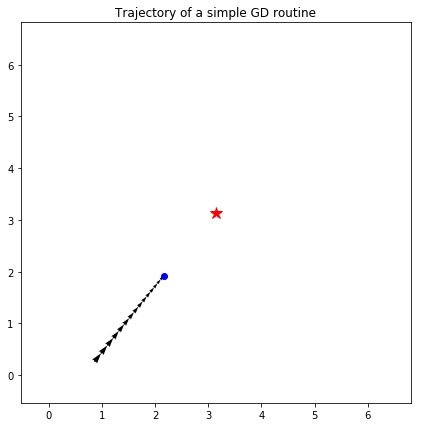

In [9]:
# Visualize the output (in 2D case).
mypath = al.wstore

if (d == 2):

    init_diff = np.linalg.norm(wstar-w_init) * 1.0
    
    myfig = plt.figure(figsize=(7,7))
    ax = myfig.add_subplot(1,1,1)
    
    ax.quiver(mypath[0,:-1], mypath[1,:-1],
              mypath[0,1:]-mypath[0,:-1],
              mypath[1,1:]-mypath[1,:-1],
              scale_units='xy', angles='xy', scale=1, color='k')
    
    ax.plot(*wstar, 'r*', markersize=12) # print true value.
    ax.plot(*mypath[:,-1], 'bo', markersize=6) # print our final estimate.
    plt.title('Trajectory of a simple GD routine')
    plt.xlim((wstar[0]-init_diff, wstar[0]+init_diff))
    plt.ylim((wstar[1]-init_diff, wstar[1]+init_diff))
    plt.show()

### Exercises (B):

0. Fixing the algorithm settings, try modifying the sample size, noise distribution. Describe how this impacts the search trajectory.

0. Fixing the data distribution settings, try modifying the algorithm settings such as the step size, number of iterations, and initial value. Describe how this impacts the search trajectory.

<a id="paraEval"></a>
## Evaluating the impact of parameter settings

The term __parameter__ is used rather loosely here: we have parameters that control our algorithm (e.g., step size $\alpha$ in the gradient descent example), and we have parameters that our algorithm seeks to learn (e.g., some $w \approx w^{\ast}$ in the example above). Borrowing a term from Bayesian statistics, one might call the former "hyperparameters" to make the distinction clear.

Anyways, here we spend a few minutes tweaking all manner of parameters, and visualizing the impact that it has on our learning algorithm's performance.

In [97]:
# Block including all the contents of the previous experiment.

# Initialize model.
mod = LeastSqLinReg()

# Initialize learning algorithm.
w_init = 10*np.random.uniform(size=(d,1))
def alpha_fixed(t, val):
    return val
def make_step(u):
    def mystep(t):
        return alpha_fixed(t=t, val=u)
    return mystep
t_max = 50
step = make_step(0.05)
al = Algo_GD(w_init=w_init,
             t_max=t_max,
             step=step,
             store=True)

# Set up for a loop over trials.
num_trials = 100
n = 50
d = 2
loss_tr = np.zeros((num_trials,t_max+1), dtype=np.float32)
loss_te = np.zeros((num_trials,t_max+1), dtype=np.float32)
truedist = np.zeros((num_trials,t_max+1), dtype=np.float32)
for tri in range(num_trials):
    
    #print("Running trial number", tri)
    data = Data()
    wstar = math.pi * np.ones((d,1), dtype=np.float32)
    X = np.random.standard_normal(size=(n*2,d))
    epsilon = np.random.standard_t(df=3, size=(n*2,1))
    y = np.dot(X,wstar) + epsilon
    data.init_tr(X=X[0:n,:], y=y[0:n,:]) # former half for training
    data.init_te(X=X[n:,:], y=y[n:,:]) # latter half for testing

    # Iterate the learning algorithm.
    idx = 1
    loss_tr[tri,0] = np.mean(mod.l_tr(w=w_init, data=data))
    loss_te[tri,0] = np.mean(mod.l_te(w=w_init, data=data))
    truedist[tri,0] = np.linalg.norm((w_init-wstar))
    for mystep in al:
        al.update(model=mod, data=data)
        # Record performance
        loss_tr[tri,idx] = np.mean(mod.l_tr(w=al.w, data=data))
        loss_te[tri,idx] = np.mean(mod.l_te(w=al.w, data=data))
        truedist[tri,idx] = np.linalg.norm((al.w-wstar))
        idx += 1
        

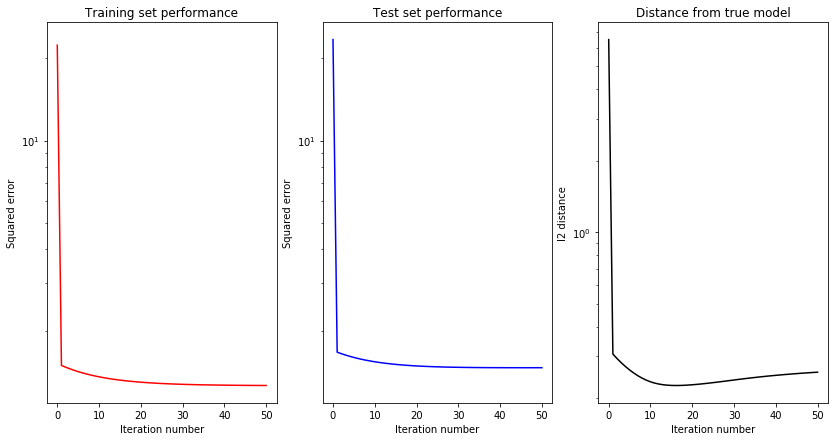

In [101]:
# Visualize the performance trajectories.

tvals = np.arange((t_max+1))

# Average over trials.
myfig = plt.figure(figsize=(14,7))

ax_tr = myfig.add_subplot(1, 3, 1)
loss_ave = np.mean(loss_tr, axis=0)
loss_sd = np.std(loss_tr, axis=0)
#plt.fill_between(tvals, loss_ave-loss_sd,
#                 loss_ave+loss_sd, color="pink")
ax_tr.semilogy(tvals, loss_ave, "-", color="red")
plt.ylabel("Squared error")
plt.xlabel("Iteration number")
plt.title("Training set performance")

ax_te = myfig.add_subplot(1, 3, 2, sharey=ax_tr)
loss_ave = np.mean(loss_te, axis=0)
loss_sd = np.std(loss_te, axis=0)
#plt.fill_between(tvals, loss_ave-loss_sd,
#                 loss_ave+loss_sd, color="lavender")
ax_te.semilogy(tvals, loss_ave, "-", color="blue")
plt.ylabel("Squared error")
plt.xlabel("Iteration number")
plt.title("Test set performance")

ax_dist = myfig.add_subplot(1, 3, 3)
dist_ave = np.mean(truedist, axis=0)
#dist_sd = np.std(truedist, axis=0)
#plt.fill_between(tvals, dist_ave-dist_sd,
#                 dist_ave+dist_sd, color="gray")
ax_dist.semilogy(tvals, dist_ave, "-", color="black")
plt.ylabel("l2 distance")
plt.xlabel("Iteration number")
plt.title("Distance from true model")

plt.show()


In the above tests, the following parameters are worth modifying:

- `n`: the sample size
- `d`: the number of parameters
- `step`: the step size method
- `t_max`: the number of iterations

### Exercises (C):

0. Investigate how modifying the underlying data distribution, sample size, and dimension impacts the error trajectory. Describe what you observe.

0. Analogously, modify the algorithm settings under fixed data settings. Describe how algorithm behavior and "optimal" settings depend on the underlying distribution.

<a id="learning"></a>
## From optimization to learning

It should be plain by this point that our algorithm object can be used to implement an optimization procedure, whose objective function is furnished by the model object, which in turn depends on the data object. That said, even if we were able to get a perfect minimizer of the objective function used, this in and of itself does *not* guarantee the quality of the learning machine, since the objective function is typically an estimator of some unknown quantity we must estimate.

The following makes this link a bit clearer. Let's consider the common scenario of risk minimization as an ideal goal:

\begin{align}
\min_{w \in \mathbb{R}^{d}} R(w), \quad R(w) = \mathbf{E}_{Z} L(w;z).
\end{align}

In practice, since the underlying distribution is unknown, all we have available to us is knowledge of $L$, and a set of data points $z_{1},\ldots,z_{n}$.

The example below starts with $R$ taking the simple form of a quadratic function, here denoted by

\begin{align}
R(w) = (w - w^{\ast})^{T}A(w - w^{\ast}) + b^2.
\end{align}

In order for the condition $\mathbf{E}_{Z} L(w;z) = R(w)$ to hold for all $w \in \mathbb{R}^{d}$, one sufficient form of the loss is the squared error under a linear regression model with additive noise, independent of the inputs.

That is, $z = (x,y)$ with

\begin{align}
y = \langle w^{\ast}, x \rangle + \varepsilon
\end{align}

and $\mathbf{E}\varepsilon^2 = b^2$, assumed to be independent of each element of random vector $x \in \mathbb{R}^{d}$, such that $\mathbf{E}\varepsilon x = 0$.

Expanding the squared term and integrating, it follows that the desired equality holds, with

\begin{align}
A = \mathbf{E}xx^{T}.
\end{align}

In the special case that $\mathbf{E}_{X}x = 0$, we naturally have $A =\text{cov}\,x$. In special cases where both $L$ and $R$ are *known*, then that provides an ideal opportunity to show how random idiosyncracies in the sample can lead to inefficient learning. On the other side of that coin, it also gives us a chance to test when modifications to the learning algorithm can overcome these issues.

Let's start by writing a function for computing $R$, following the above setup.

In [105]:
def riskMaker(w, A, b, wstar):
    diff = w - wstar
    quad = np.dot(np.transpose(diff), np.dot(A,diff).reshape(diff.shape))
    return np.float32(quad) + b**2

In [106]:
# Prepare the risk-related parameters.
epsilon_sd = 2.0
X_sd = 1.0
X_cov = X_sd * np.eye(d)
wstar = math.pi * np.ones((d,1), dtype=np.float32)

In [107]:
# Put together risk function.
def risk(w):
    return riskMaker(w=w, A=X_cov, b=epsilon_sd, wstar=wstar)

In [115]:
# Generate data.
data = Data()
n = 15
d = 2
X = np.random.normal(loc=0.0, scale=X_sd, size=(n,d))
epsilon = np.random.normal(loc=0.0, scale=epsilon_sd, size=(n,1))
y = np.dot(X,wstar) + epsilon
data.init_tr(X=X, y=y) # all for training

In [116]:
# Initialize model.
mod = LeastSqLinReg()

In [117]:
# Initialize learning algorithm.
w_init = np.random.uniform(size=(d,1))
def alpha_fixed(t, val):
    return val
def make_step(u):
    def mystep(t):
        return alpha_fixed(t=t, val=u)
    return mystep
al = Algo_GD(w_init=w_init,
             t_max=15,
             step=make_step(0.05),
             store=True)

In [118]:
# Iterate the learning algorithm.
for mystep in al:
    al.update(model=mod, data=data)

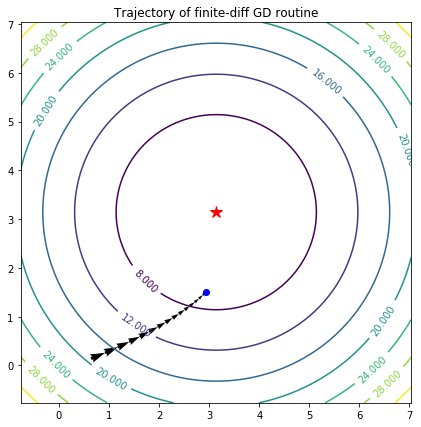

In [119]:
import matplotlib
import matplotlib.pyplot as plt

# Visualize the output (in 2D case).
mypath = al.wstore

def risk2D_helper(w1, w2):
    w2D = np.array([w1,w2]).reshape((2,1))
    return risk(w=w2D)

risk2D = np.vectorize(risk2D_helper)

if (d == 2):

    tmpdel = np.linalg.norm(wstar-w_init) * 1
    xvals = np.arange(wstar[0]-tmpdel,wstar[0]+tmpdel, 0.1)
    yvals = np.arange(wstar[1]-tmpdel,wstar[1]+tmpdel, 0.1)
    X, Y = np.meshgrid(xvals, yvals)
    Z = risk2D(w1=X, w2=Y)

    myfig = plt.figure(figsize=(7,7))
    ax = myfig.add_subplot(1,1,1)
    CS = ax.contour(X, Y, Z)
    ax.quiver(mypath[0,:-1], mypath[1,:-1],
              mypath[0,1:]-mypath[0,:-1],
              mypath[1,1:]-mypath[1,:-1],
              scale_units='xy', angles='xy', scale=1, color='k')
    CS.clabel(inline=1, fontsize=10)
    ax.plot(*wstar, 'r*', markersize=12) # print true value.
    ax.plot(*mypath[:,-1], 'bo', markersize=6) # print our final estimate.
    plt.title('Trajectory of GD routine')
    plt.show()

In this way, we see how there is some unseen "true" objective function (here $R$, computed by `risk`) underlying the learning algorithm, which carries out optimization of a quantity that approximates this true risk. In the case of gradient descent, ideally we would like to use the gradient of the risk $\nabla R(w_{(t)})$ at each step, but since this is unobservable, we settle for the empirical mean of $\nabla L(w;z)$.

### Exercises (D):


0. With contours of the "true" objective, namely the risk now available, once again try modifying the parameters controlling the underlying distribution and the algorithm.

0. Using concepts such as "generalization" and "overfitting", describe the phenomena that are observed.

<a id="FDGD"></a>
## More examples: finite-difference GD

With some basic ideas covered, we can proceed with some modifications of the gradient descent procedure to study new learning algorithms. A full-fledged implementation of GD requires access to the gradient. In the least-squares model implemented above, we had this, but there are situations in which the gradient, even if it exists, is not easily computable, even if the loss itself is (e.g., cases where the loss itself is defined implicitly).

In such settings, assuming the loss is sufficiently smooth, we can easily approximate the gradient using finite-difference methods, well-known since at least the time of Euler. Applying a perturbation to one coordinate at a time,

\begin{align}
\Delta_{j} & = (0,\ldots,\delta,\ldots,0), \text{ such that} \\
w + \Delta_{j} & = (w_{1},\ldots,(w_{j}+\delta),\ldots,w_{d}), \quad j = 1,\ldots,d 
\end{align}

we can take finite differences to approximate the partial derivatives of interest, 

\begin{align}
\widehat{g}_{i,j}(w) & = \frac{L((w+\Delta_{j});z_{i})-L(w;z_{i})}{\delta} \approx \frac{\partial L(w;z_{i})}{\partial w_{j}}, \quad i=1,\ldots,n \\
\widehat{g}_{i}(w) & = \left(\widehat{g}_{i,1}(w),\ldots,\widehat{g}_{i,d}(w)\right), \quad i=1,\ldots,n.
\end{align}

The procedure implemented here simply replaces the true gradients with their finite-difference approximations, evaluated at each point, namely we update using

\begin{align}
w_{(t+1)} = w_{(t)} - \alpha \frac{1}{n}\sum_{i=1}^{n} \widehat{g}_{i}(w_{(t)}).
\end{align}

The implementation is straightforward, as below.

In [165]:
class Algo_FDGD:
    '''
    Modification of gradient descent procedure to use
    an approximation of the gradient via finite-diffs.
    '''
    
    def __init__(self, w_init, t_max, step, delta, store):
        self.w = w_init
        self.t = None
        self.t_max = t_max
        self.step = step
        self.store = store
        self.delta = delta
        self.delmtx = np.eye(self.w.size) * delta
        
        # Keep record of all updates (optional).
        if self.store:
            self.wstore = np.zeros((self.w.size,t_max+1), dtype=np.float32)
            self.wstore[:,0] = self.w.flatten()
        else:
            self.wstore = None
        
    def __iter__(self):
        self.t = 0
        return self
        
    def __next__(self):
        if self.t >= self.t_max:
            raise StopIteration
        
    def newdir(self, model, data):
        
        out = np.zeros(self.w.shape, dtype=self.w.dtype)
        loss = model.l_tr(w=self.w, data=data)
        
        # Perturb one coordinate at a time, compute finite difference.
        for j in range(self.w.size):
            delj = np.take(self.delmtx,[j],axis=1)
            loss_delta = model.l_tr((self.w + delj), data=data)
            out[j,:] = np.mean(loss_delta-loss) / self.delta
            
        return out * (-1)

    def update(self, model, data):
        
        # Parameter update.
        stepsize = self.step(self.t)
        newdir = self.newdir(model=model, data=data)
        self.w = self.w + stepsize * newdir
        
        # Monitor update.
        self.t += 1
        
        # Keep record of all updates (optional).
        if self.store:
            self.wstore[:,self.t] = self.w.flatten()


We can do perfectly analogous tests as in the previous set of experiments, with the only addition being that we must provide a `delta` parameter, namely the size of perturbation $\delta$ above.

In [155]:
def riskMaker(w, A, b, wstar):
    diff = w - wstar
    quad = np.dot(np.transpose(diff), np.dot(A,diff).reshape(diff.shape))
    return np.float32(quad) + b**2

In [156]:
# Prepare the risk-related parameters.
epsilon_sd = 2.0
X_sd = 1.0
X_cov = X_sd * np.eye(d)
wstar = math.pi * np.ones((d,1), dtype=np.float32)

In [157]:
# Put together risk function.
def risk(w):
    return riskMaker(w=w, A=X_cov, b=epsilon_sd, wstar=wstar)

In [158]:
# Generate data.
data = Data()
n = 15
d = 2
X = np.random.normal(loc=0.0, scale=X_sd, size=(n,d))
epsilon = np.random.normal(loc=0.0, scale=epsilon_sd, size=(n,1))
y = np.dot(X,wstar) + epsilon
data.init_tr(X=X, y=y) # all for training

In [159]:
# Initialize model.
mod = LeastSqLinReg()

In [160]:
# Initialize learning algorithm.
w_init = np.random.uniform(size=(d,1))
def alpha_fixed(t, val):
    return val
def make_step(u):
    def mystep(t):
        return alpha_fixed(t=t, val=u)
    return mystep
al = Algo_FDGD(w_init=w_init,
               t_max=15,
               step=make_step(0.05),
               delta=0.01,
               store=True)

In [161]:
# Iterate the learning algorithm.
for mystep in al:
    al.update(model=mod, data=data)

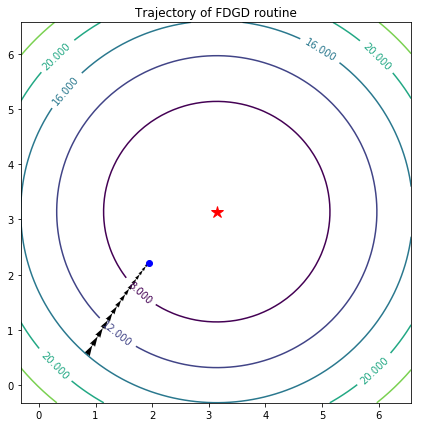

In [163]:
import matplotlib
import matplotlib.pyplot as plt

# Visualize the output (in 2D case).
mypath = al.wstore

def risk2D_helper(w1, w2):
    w2D = np.array([w1,w2]).reshape((2,1))
    return risk(w=w2D)

risk2D = np.vectorize(risk2D_helper)

if (d == 2):

    tmpdel = np.linalg.norm(wstar-w_init) * 1
    xvals = np.arange(wstar[0]-tmpdel,wstar[0]+tmpdel, 0.1)
    yvals = np.arange(wstar[1]-tmpdel,wstar[1]+tmpdel, 0.1)
    X, Y = np.meshgrid(xvals, yvals)
    Z = risk2D(w1=X, w2=Y)

    myfig = plt.figure(figsize=(7,7))
    ax = myfig.add_subplot(1,1,1)
    CS = ax.contour(X, Y, Z)
    ax.quiver(mypath[0,:-1], mypath[1,:-1],
              mypath[0,1:]-mypath[0,:-1],
              mypath[1,1:]-mypath[1,:-1],
              scale_units='xy', angles='xy', scale=1, color='k')
    CS.clabel(inline=1, fontsize=10)
    ax.plot(*wstar, 'r*', markersize=12) # print true value.
    ax.plot(*mypath[:,-1], 'bo', markersize=6) # print our final estimate.
    plt.title('Trajectory of FDGD routine')
    plt.show()
    


As some extra practice, the above algorithm implements the *forward difference* approximation of $\nabla L(w;z)$, but this is by no means the only approximation, nor is it the best.

For example, we have

\begin{align}
\frac{l(w;z_{i})-l(w-\Delta_{j} ;z_{i})}{\delta} \quad \text{and} \quad \frac{l(w+\Delta_{j};z_{i})-l(w-\Delta_{j};z_{i})}{2\delta}
\end{align}

respectively known as the *backward difference* and *central difference* approximations of the $j$th partial derivative.

### Exercises (E):

0. Modify `Algo_FDGD` or create a new class to implement these two approaches. How do they compare with the original in terms of their trajectory? Their rate of convergence? Their robustness as $n$ becomes small?

<a id="SGD"></a>
## More examples: stochastic GD

When we have many controllable parameters $w=(w_{1},\ldots,w_{d})$, that means that we must compute many partial derivatives in order to acquire the gradient of the loss evaluated at any given point. When we have $n$ observations and large $d$, this can be computationally prohibitive in an iterative scheme such as the one explored above.

One way around this is to take a random sub-sample of the data, often called a *mini-batch*, and to run standard gradient descent on this smaller set. That is, we randomly choose indices

\begin{align}
\mathcal{I} \subset \{1,2,\ldots,n\}
\end{align}

with size $B = |\mathcal{I}| \ll n$. We then compute the mini-batch gradient

\begin{align}
w_{(t+1)} = w_{(t)} - \alpha_{(t)} \frac{1}{B}\sum_{i \in \mathcal{I}} \nabla L(w_{(t)};z_{i}).
\end{align}

The classical case is where $B=1$, and is typically considered the canonical form of *stochastic gradient descent* (SGD). More generally, say each $i \in \mathcal{I}$ is sampled independently and uniformly from $\{1,\ldots,n\}$, then taking expectation with respect to these random indices, for any $w$,

\begin{align}
\mathbf{E} \left( \frac{1}{B}\sum_{i \in \mathcal{I}} \nabla L(w;z_{i}) \right) & = \frac{1}{B}\sum_{i \in \mathcal{I}} \mathbf{E} \nabla L(w;z_{i})\\
 & = \frac{1}{B}\sum_{i \in \mathcal{I}}\left(\frac{1}{n} \sum_{j=1}^{n} \nabla L(w;z_{j}) \right)\\
 & = \frac{1}{n} \sum_{j=1}^{n} \nabla L(w;z_{j}).
\end{align}

That is, the expected value of this random quantity the "full gradient" itself. The hope is that after a sufficient number of inexpensive iterations, this variance will iron itself out. Let's implement this it to see how the algorithm behaves first-hand. All it requires is a couple lines for sub-sampling within the `newdir` function.

In [166]:
class Algo_SGD:
    '''
    Modification of gradient descent routine, which uses
    randomly selected mini-batches for fast (but noisy)
    iterations.
    '''
    
    def __init__(self, w_init, t_max, step, batchsize, store):
        self.w = w_init
        self.t = None
        self.t_max = t_max
        self.step = step
        self.batchsize = batchsize
        self.store = store
        
        # Keep record of all updates (optional).
        if self.store:
            self.wstore = np.zeros((self.w.size,t_max+1), dtype=np.float32)
            self.wstore[:,0] = self.w.flatten()
        else:
            self.wstore = None
        
    def __iter__(self):
        self.t = 0
        return self
        
    def __next__(self):
        if self.t >= self.t_max:
            raise StopIteration
        
    def newdir(self, model, data):
        idx = np.random.choice(a=data.X_tr.shape[0], size=self.batchsize, replace=True)
        data_sub = Data()
        data_sub.init_tr(X=data.X_tr[idx,:],y=data.y_tr[idx,:])
        return (-1) * np.mean(model.g_tr(w=self.w, data=data_sub), axis=0, keepdims=True)
    
    def update(self, model, data):
        
        # Parameter update.
        stepsize = self.step(self.t)
        newdir = self.newdir(model=model, data=data)
        self.w = self.w + stepsize * np.transpose(newdir)
        
        # Monitor update.
        self.t += 1
        
        # Keep record of all updates (optional).
        if self.store:
            self.wstore[:,self.t] = self.w.flatten()


In [167]:
def riskMaker(w, A, b, wstar):
    diff = w - wstar
    quad = np.dot(np.transpose(diff), np.dot(A,diff).reshape(diff.shape))
    return np.float32(quad) + b**2

In [168]:
# Prepare the risk-related parameters.
epsilon_sd = 2.0
X_sd = 1.0
X_cov = X_sd * np.eye(d)
wstar = math.pi * np.ones((d,1), dtype=np.float32)

In [169]:
# Put together risk function.
def risk(w):
    return riskMaker(w=w, A=X_cov, b=epsilon_sd, wstar=wstar)

In [170]:
# Generate data.
data = Data()
n = 15
d = 2
X = np.random.normal(loc=0.0, scale=X_sd, size=(n,d))
epsilon = np.random.normal(loc=0.0, scale=epsilon_sd, size=(n,1))
y = np.dot(X,wstar) + epsilon
data.init_tr(X=X, y=y) # all for training

In [171]:
# Initialize model.
mod = LeastSqLinReg()

In [178]:
# Initialize learning algorithm.
w_init = np.random.uniform(size=(d,1))
def alpha_fixed(t, val):
    return val
def make_step(u):
    def mystep(t):
        return alpha_fixed(t=t, val=u)
    return mystep
al = Algo_SGD(w_init=w_init,
              t_max=15,
              step=make_step(0.05),
              batchsize=1,
              store=True)

In [179]:
# Iterate the learning algorithm.
for mystep in al:
    al.update(model=mod, data=data)

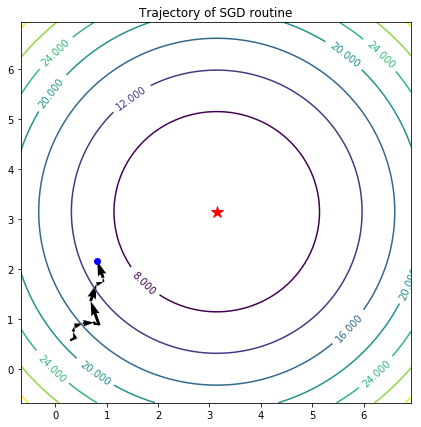

In [181]:
import matplotlib
import matplotlib.pyplot as plt

# Visualize the output (in 2D case).
mypath = al.wstore

def risk2D_helper(w1, w2):
    w2D = np.array([w1,w2]).reshape((2,1))
    return risk(w=w2D)

risk2D = np.vectorize(risk2D_helper)

if (d == 2):

    tmpdel = np.linalg.norm(wstar-w_init) * 1
    xvals = np.arange(wstar[0]-tmpdel,wstar[0]+tmpdel, 0.1)
    yvals = np.arange(wstar[1]-tmpdel,wstar[1]+tmpdel, 0.1)
    X, Y = np.meshgrid(xvals, yvals)
    Z = risk2D(w1=X, w2=Y)

    myfig = plt.figure(figsize=(7,7))
    ax = myfig.add_subplot(1,1,1)
    CS = ax.contour(X, Y, Z)
    ax.quiver(mypath[0,:-1], mypath[1,:-1],
              mypath[0,1:]-mypath[0,:-1],
              mypath[1,1:]-mypath[1,:-1],
              scale_units='xy', angles='xy', scale=1, color='k')
    CS.clabel(inline=1, fontsize=10)
    ax.plot(*wstar, 'r*', markersize=12) # print true value.
    ax.plot(*mypath[:,-1], 'bo', markersize=6) # print our final estimate.
    plt.title('Trajectory of SGD routine')
    plt.show()
    


Just as in the other experiments, experimentation with key parameters should be illustrative.

### Exercises (F):

0. Investigate how modifying the underlying data distribution, sample size, and dimension impacts the error trajectory. Describe what you observe.

0. Analogously, modify the algorithm settings under fixed data settings. Describe how algorithm behavior and "optimal" settings depend on the underlying distribution.

<a id="SVRG"></a>
## More examples:

Under construction.

## References:

- P. Frey MA691 course notes, "The finite difference method". (https://www.ljll.math.upmc.fr/frey/ma691.html)
- Rakhlin, Alexander, Ohad Shamir, and Karthik Sridharan. "Making Gradient Descent Optimal for Strongly Convex Stochastic Optimization." ICML. 2012. arXiv URL: https://arxiv.org/abs/1109.5647